In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Oct_weekend.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 1578.261807
  (4,4) => 0.0
  (3,1) => 2411.844069
  (4,5) => 282.057506
  (2,4) => 2317.190422
  (6,5) => 1335.849799
  (8,4) => 2022.804133
  (1,2) => 0.0
  (5,1) => 0.586813
  (3,4) => 22.724112
  (8,2) => 5.0e-6
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 1333.566481
  (2,1) => 0.00224
  (2,5) => 0.0
  (8,5) => 811.896026
  (1,4) => 0.0
  (2,8) => 0.0
  (5,8) => 2.0e-6
  (4,8) => 2106.354105
  (7,8) => 1330.602705
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 2.0e-6
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Oct_dict = readall("../temp_files/link_day_minute_Oct_dict_JSON_adjusted.json");
link_day_minute_Oct_dict = replace(link_day_minute_Oct_dict, "NaN", 0);

link_day_minute_Oct_dict = JSON.parse(link_day_minute_Oct_dict);

In [12]:
# weekend_Oct_list = [6, 7, 13, 14, 20, 21, 27, 28]

# training set 1
weekend_Oct_list_1 = [6, 7, 13, 14, 20, 21]

# training set 2
weekend_Oct_list_2 = [13, 14, 20, 21, 27, 28]

# training set 3
weekend_Oct_list_3 = [6, 7, 13, 21, 27, 28]

arcs_1 = Dict{(Int, Int), Arc}[]
for j in weekend_Oct_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["MD_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in weekend_Oct_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["MD_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in weekend_Oct_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["MD_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [14]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [1578.261807,1578.261807,1578.261807,1578.261807,1578.261807,1578.26…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [2411.844069,2411.844069,2411.844069,2411.844069,2411.844069,2411.84…
  (4,5) => [282.057506,282.057506,282.057506,282.057506,282.057506,282.057506]
  (2,4) => [2317.190422,2317.190422,2317.190422,2317.190422,2317.190422,2317.19…
  (6,5) => [1335.849799,1335.849799,1335.849799,1335.849799,1335.849799,1335.84…
  (8,4) => [2022.804133,2022.804133,2022.804133,2022.804133,2022.804133,2022.80…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [0.586813,0.586813,0.586813,0.586813,0.586813,0.586813]
  (3,4) => [22.724112,22.724112,22.724112,22.724112,22.724112,22.724112]
  (8,2) => [5.0e-6,5.0e-6,5.0e-6,5.0e-6,5.0e-6,5.0e-6]
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (2,6) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (5,4) => [1333.566481,1333.566481,1333.566481,1333.566481,1333.566481,1333.56…
  (2,1) => [0.00224,0.00224,0.00224,0.

In [15]:
flow_data_3

24x6 Array{Float64,2}:
 5680.78         4088.0    3354.92   1205.03         3750.55   3297.7       
 2633.05         3092.93   1990.76   1453.75         2415.6    2964.01      
  952.124        1304.21    477.738  1500.96         1398.74   2471.09      
 1014.88         1614.83   1447.93   1443.76          749.55   5113.04      
  484.516        2134.8     773.546  3245.12         1035.1    1031.43      
 2409.14         3029.13   3275.01   2481.67         3153.5    3391.63      
 2434.39         3975.44   3203.01   2726.97         2278.91   4664.67      
 2238.88         3035.75   2371.1    3120.88         2205.0    2808.73      
 1507.79         1378.19   1346.89   1424.63          816.27   3455.55      
  373.536        2879.14   1017.0    2538.24          949.668  4073.29      
 1655.73         2739.92   2382.91   1425.0          1050.11   5345.34      
  521.827        2212.26   1691.16   3139.18         3086.54   3283.91      
  770.685        1703.68   1133.66   2691.23         

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")

coeffs_dict_Oct_weekend = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Oct_weekend[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Oct_weekend[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Oct_weekend[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [18]:
outfile = open("../temp_files/coeffs_dict_Oct_weekend.json", "w")

JSON.print(outfile, coeffs_dict_Oct_weekend)

close(outfile)

In [19]:
coeffs_dict_Oct_weekend_ = readall("../temp_files/coeffs_dict_Oct_weekend.json")
coeffs_dict_Oct_weekend_ = JSON.parse(coeffs_dict_Oct_weekend_)

Dict{String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.00023762293292620105,2.6882681024882e-5,1.054372…
  "(5,0.5,100.0,3)"   => {1.0,0.00011585294482652628,0.0016533559733197323,-0.00…
  "(6,1.5,10.0,3)"    => {1.0,0.00024084604492207183,-4.2979663371406265e-6,-2.3…
  "(6,2.0,0.1,2)"     => {1.0,4.422468287247082e-5,0.0006767718693832894,-0.0027…
  "(4,0.5,1000.0,1)"  => {1.0,0.0002185493408773137,0.00047790622798218153,-0.00…
  "(6,2.0,0.01,1)"    => {1.0,0.0006309202422399461,-0.005215976318613863,0.0145…
  "(8,1.5,0.01,1)"    => {1.0,0.0006517625083894229,-0.005832660098302649,0.0171…
  "(5,1.5,1.0,1)"     => {1.0,0.000382714351479679,-0.0011008545998248268,-0.000…
  "(8,2.5,0.001,2)"   => {1.0,1.750841238128029e-5,0.00023723763197984878,0.0013…
  "(4,2.0,0.1,1)"     => {1.0,0.00039146021087469357,-0.0012319496527992595,0.00…
  "(5,1.0,1000.0,2)"  => {1.0,0.00010332434436194602,-0.000361808816789043,-0.00…
  "(4,2.0,0.1,2)"     => {1.0,7.588700553165922e-5,1.1237303404

In [20]:
coeffs_dict_Oct_weekend_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
  1.0        
  0.000222195
 -0.00969869 
  0.160275   
 -0.799306   
  1.83943    
 -2.26074    
  1.42648    
 -0.363628   

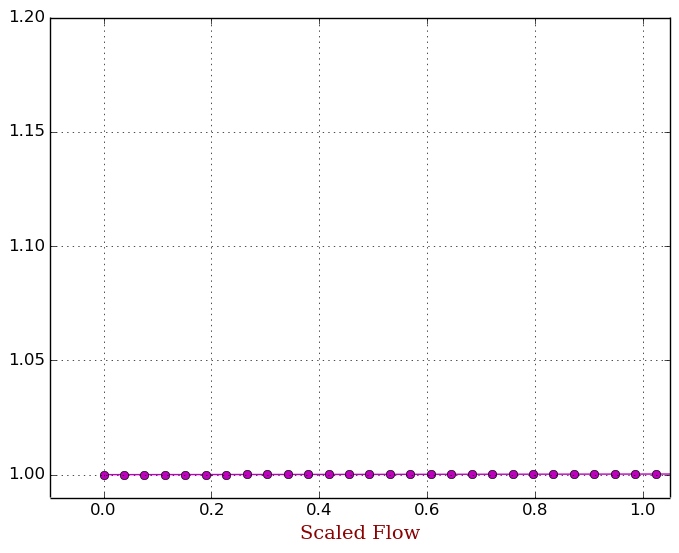

In [24]:
using PyPlot

fcoeffs = coeffs_dict_Oct_weekend_["(6,2.5,10000.0,3)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Oct_weekend")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Oct_weekend.pdf")